In [1]:
from __future__ import print_function
from __future__ import division

import pdb
import sys
import os
import yaml

import numpy as np
import scipy.optimize as opt
from scipy import interpolate
import scipy.io as sio
import scipy.special as spf

## import diffrantion integral solver from Optics folder
project_path = ('/Users/chair/Documents/Academia/SuperRes/Biteen_colab/'
    +
    'Mispolarization/python/gitted'
    )
optics_path = project_path + '/Optics'
sys.path.append(optics_path)
# sys.path.append(date_dir)
import diffraction_int as diffi
import fibonacci as fib

## Read parameter file to obtain physical properties 
## of molecule and plasmon, molecule and imaging system.
parameter_files_path = (
    project_path + '/parameter_files'
)

curly_yaml_file_name = '/curly_nrod_water_JC.yaml'
parameters = yaml.load(open(parameter_files_path+curly_yaml_file_name,'r'))


modules_path = project_path + '/solving_problems/modules'
sys.path.append(modules_path)

import fitting_misLocalization as fit

## plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
get_ipython().magic('matplotlib inline')
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rcParams['text.usetex'] = True

## colorbar stuff 
from mpl_toolkits import axes_grid1

## Import analytic expressions for the focused fields from a point dipole.
import anal_foc_diff_fields as afi

## Import computational solution to two coupled oscillators of arbitrarty 
## anisotropic polarizabilities. 
# import coupled_dipoles as cp 

## Import physical constants from yaml file.
phys_const_file_name = '/physical_constants.yaml'
opened_constant_file = open(
    parameter_files_path+phys_const_file_name,
    'r')
constants = yaml.load(opened_constant_file)
e = constants['physical_constants']['e']
c = constants['physical_constants']['c']  # charge of electron in statcoloumbs
hbar =constants['physical_constants']['hbar']
nm = constants['physical_constants']['nm']
n_a = constants['physical_constants']['nA']   # Avogadro's number
# Z_o = 376.7303 # impedence of free space in ohms (SI)

## Define some useful constants from defined parameters
n_b = parameters['general']['background_ref_index']
eps_b = n_b**2.
# a = parameters['plasmon']['radius']



#######################################################################
## Optics stuff.  
sensor_size = parameters['optics']['sensor_size']*nm
# height = 2*mm  # also defines objective lens focal length 
# height = parameters['optics']['obj_f_len']
resolution = parameters['optics']['sensor_pts']  # image grid resolution
## Build image sensor
eye = diffi.observation_points(
    x_min= -sensor_size/2, 
    x_max= sensor_size/2,
    y_min= -sensor_size/2, 
    y_max= sensor_size/2, 
    points= resolution
    )

## Experimental parameters
magnification = parameters['optics']['magnification']
numerical_aperture = parameters['optics']['numerical_aperture']
max_theta = np.arcsin(numerical_aperture) # defines physical aperture size

## numerical parameters for calculation of scattered field
lens_points = parameters['optics']['lens_points']

# obj_f = 1.*mm  # still dont know what this is supposed to be
obj_f = parameters['optics']['obj_f_len']

tube_f = magnification * obj_f

## calculate dipole magnitudes
drive_hbar_omega = parameters['general']['drive_energy'] ## rod long mode max at 1.8578957289256757 eV
omega_drive = drive_hbar_omega/hbar  # driving frequency

reading parameters from /Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/parameter_files/curly_nrod_water_JC.yaml
reading parameters from /Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/parameter_files/curly_nrod_water_JC.yaml
polarizability reduced by factor of 1
coupling scaled up by by factor of 1


##### setup warning tracker

In [2]:
import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

Load Curly's dipole locations

In [3]:
curlys_dipole_locations_file = sio.loadmat(
    '/Users/chair//Documents/Academia/SuperRes/Biteen_colab/from_Biteen_group/dipole_positions.mat'
    )

In [4]:
curlys_dipole_locations_file['dipole_pos'].shape

(73, 2)

In [5]:
curlys_dipole_locations = np.hstack(
    [curlys_dipole_locations_file['dipole_pos'],
    np.zeros((73, 1))]
    )

In [6]:
curlys_dipole_locations.shape

(73, 3)

In [7]:
def fixed_ori_mol_placement(x_min=0, x_max=500, y_min=0, y_max=500, mol_grid_pts_1D = 3, mol_angle=0):
    locations = diffi.observation_points(x_min, x_max, y_min, y_max, points=mol_grid_pts_1D)[0]
    locations = np.hstack((locations,np.zeros((locations.shape[0],1))))
    
    mol_linspace_pts = mol_grid_pts_1D
#     random_mol_angles= (np.random.random(mol_linspace_pts**2)*np.pi*2)
    return [locations, mol_angle]

### Modeling Curly's Dipoles

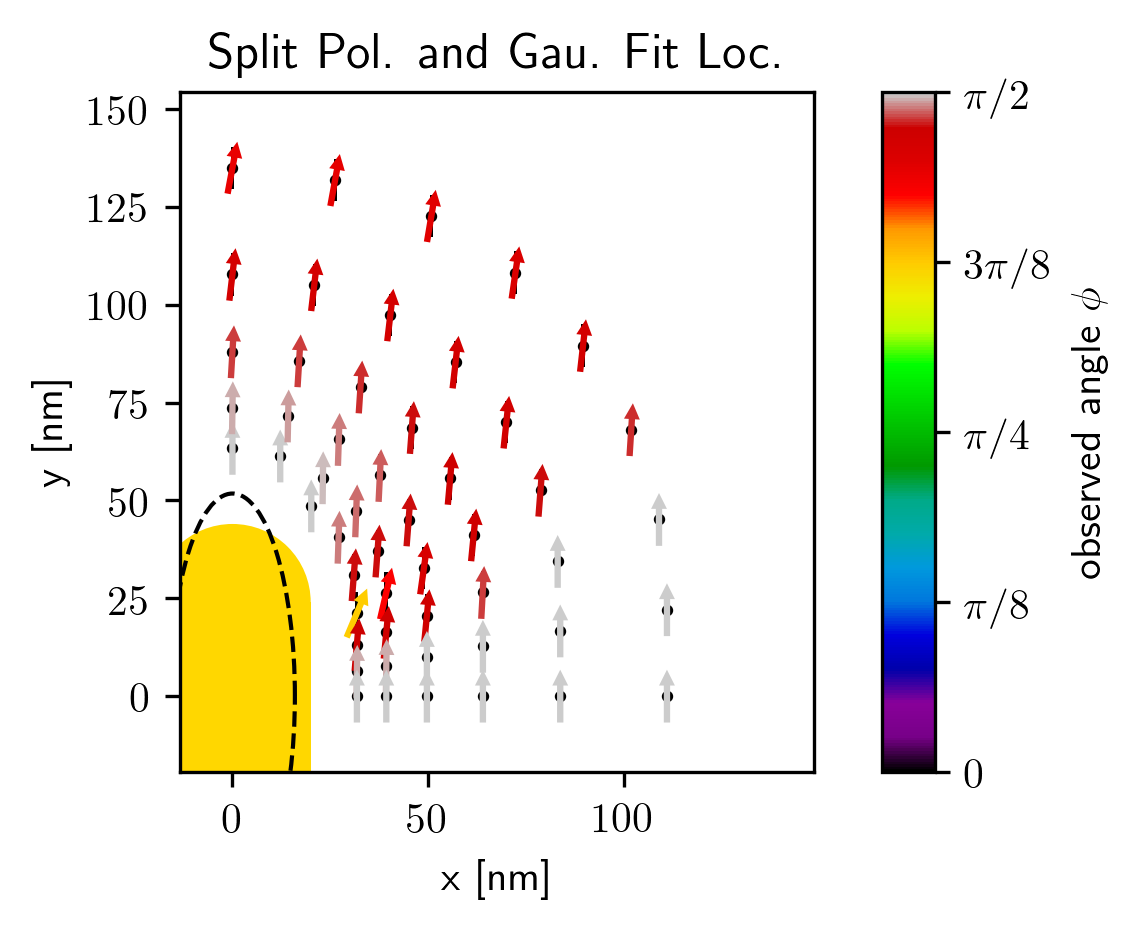

In [10]:
curly_mod_inst_y = fit.MolCoupNanoRodExp(curlys_dipole_locations, mol_angle=np.pi/2, isolate_mode=None)
curly_mod_inst_y.plot_mispol_map()

long mode tuned molecule's mispolarize towards trans axis

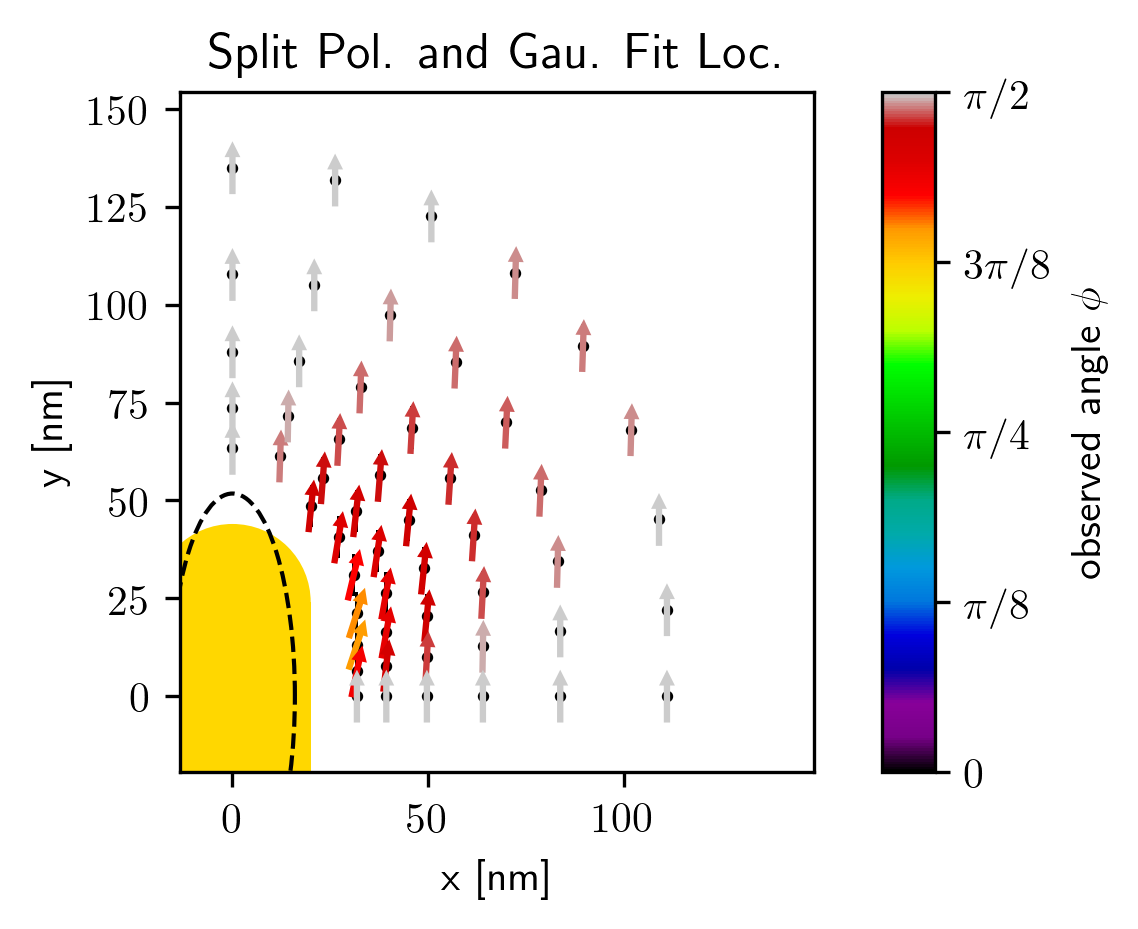

In [8]:
curly_mod_inst_y = fit.MolCoupNanoRodExp(curlys_dipole_locations, mol_angle=np.pi/2, isolate_mode='trans')
curly_mod_inst_y.plot_mispol_map()

Removing long mode changes little, so molecules are coupling into trans mode

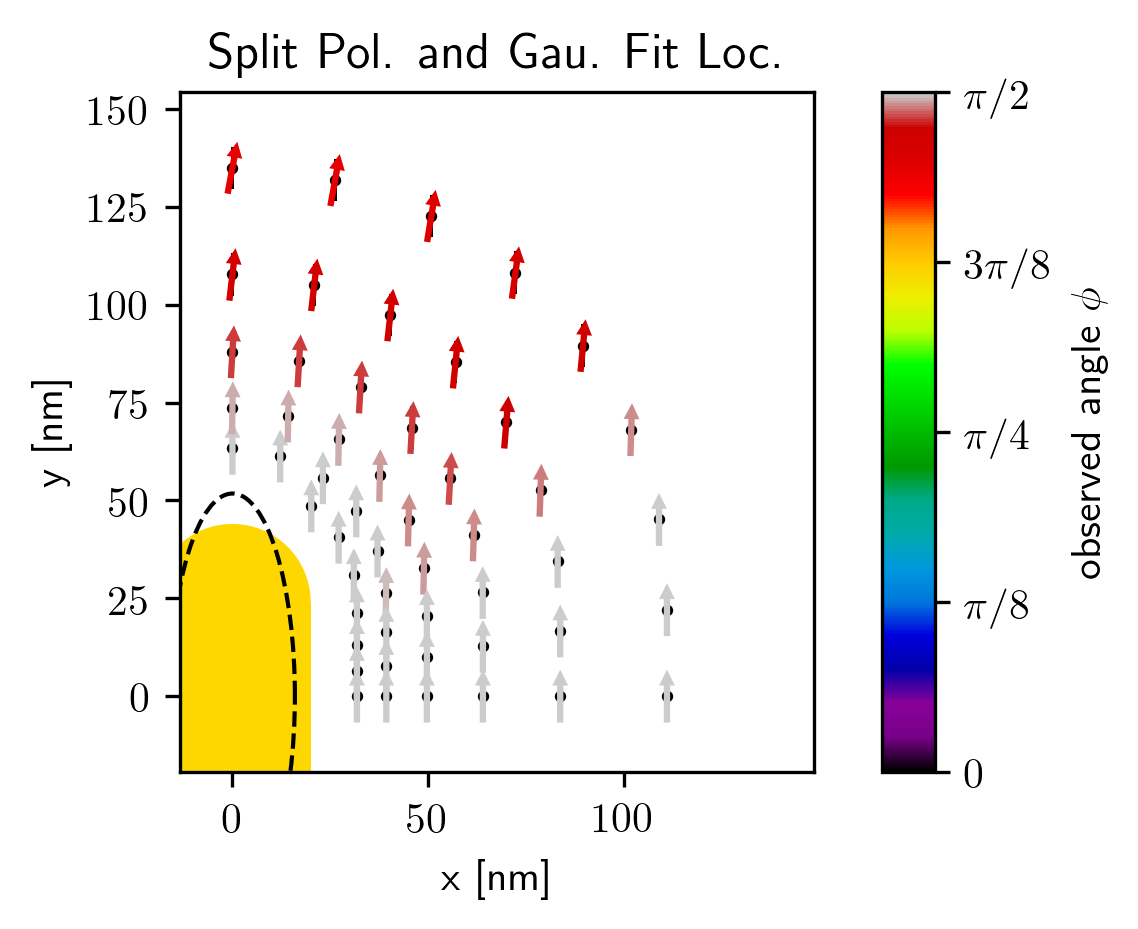

In [9]:
curly_mod_inst_y = fit.MolCoupNanoRodExp(curlys_dipole_locations, mol_angle=np.pi/2, isolate_mode='long')
curly_mod_inst_y.plot_mispol_map()

removing trans mode removes most of mispolarization towards trans axis. some interference induced mispolarization remains for molecules with strong p||d||p coupling /_|/_

## Try same plots at trans peak (2.4 eV)

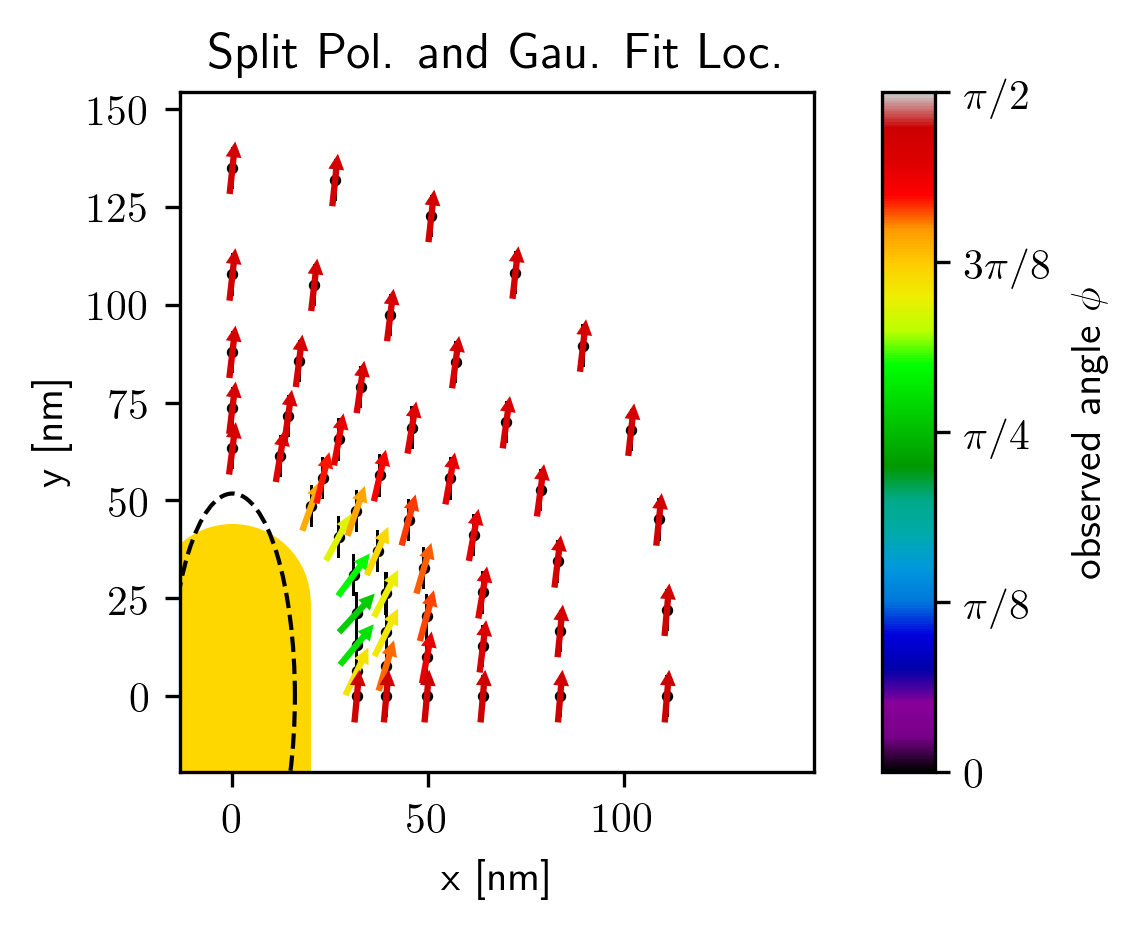

In [12]:
curly_mod_inst_y = fit.MolCoupNanoRodExp(
    curlys_dipole_locations, 
    mol_angle=np.pi/2, 
    isolate_mode=None, 
    drive_energy_eV=2.4
    )
curly_mod_inst_y.plot_mispol_map()

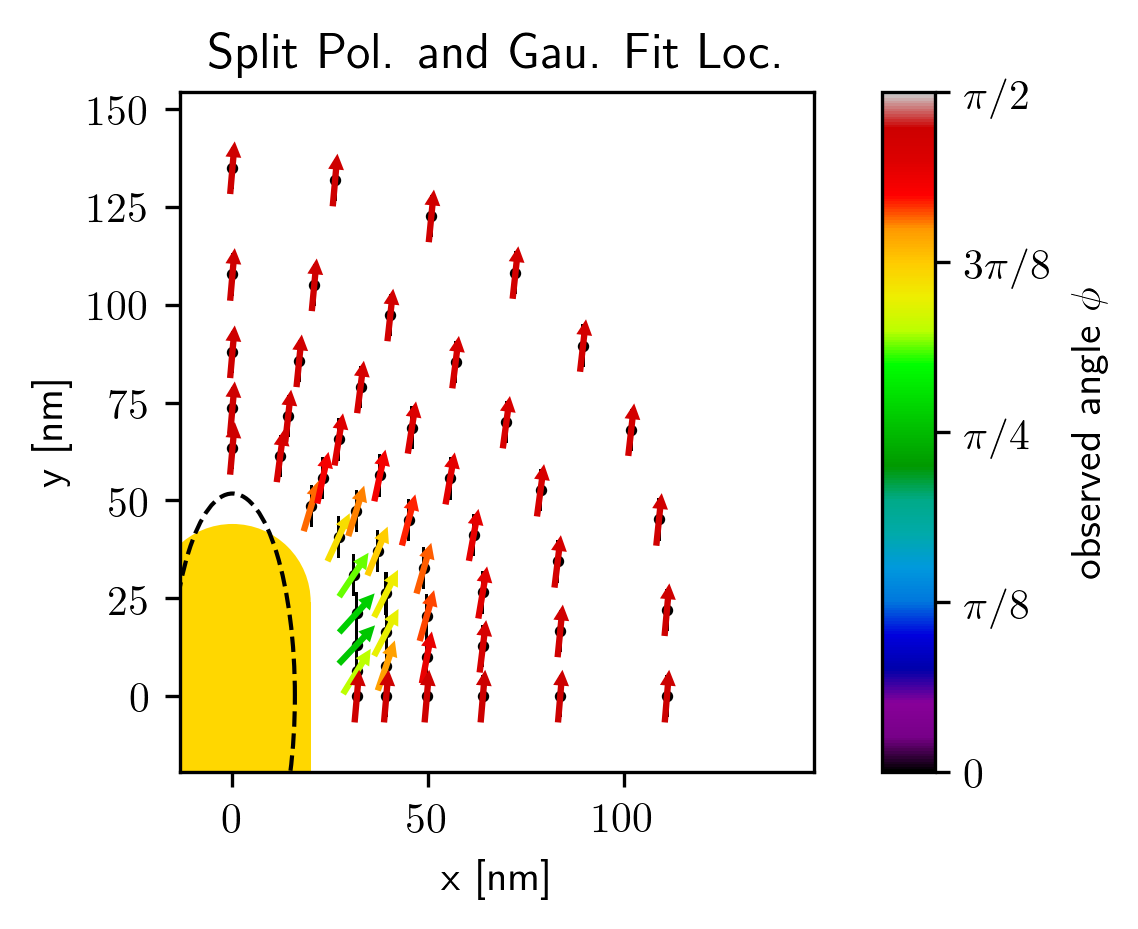

In [13]:
curly_mod_inst_y = fit.MolCoupNanoRodExp(
    curlys_dipole_locations, 
    mol_angle=np.pi/2, 
    isolate_mode='trans', 
    drive_energy_eV=2.4
    )
curly_mod_inst_y.plot_mispol_map()

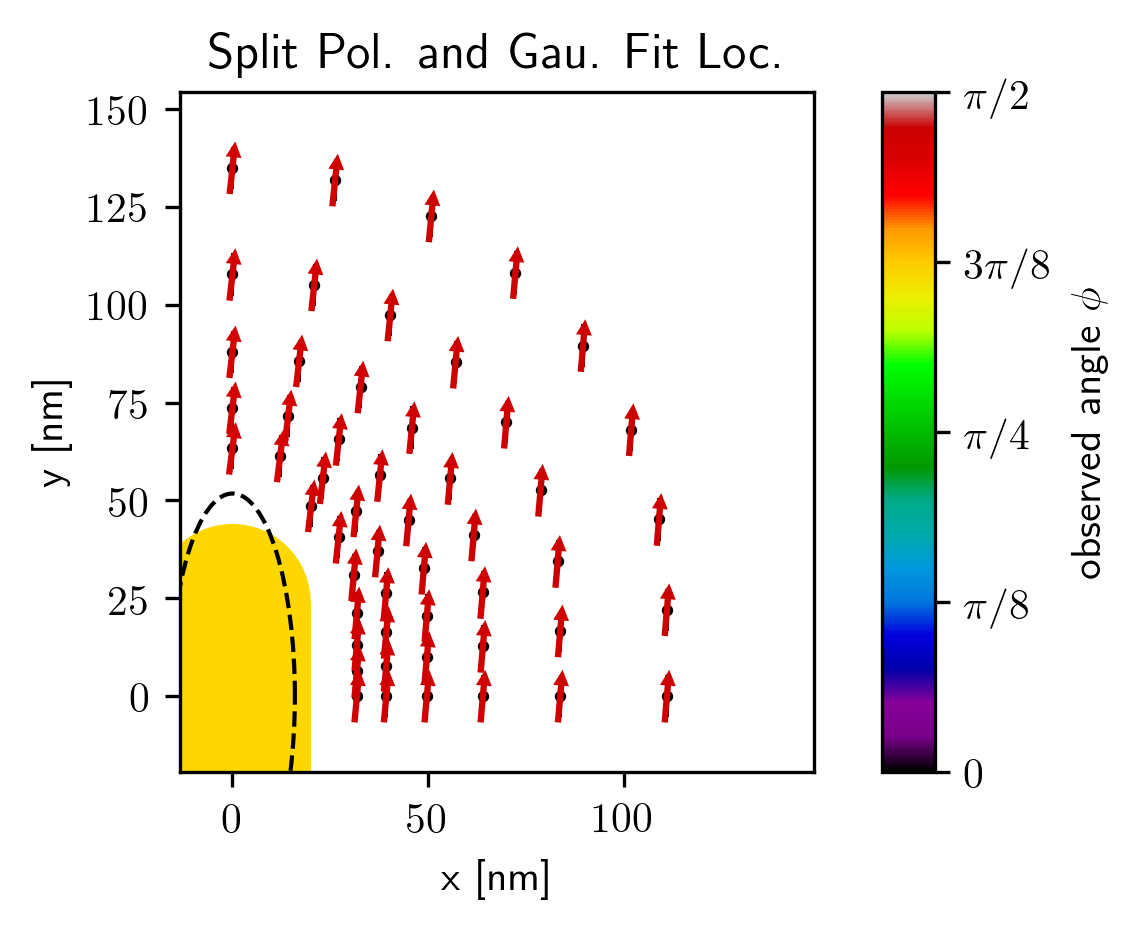

In [14]:
curly_mod_inst_y = fit.MolCoupNanoRodExp(
    curlys_dipole_locations, 
    mol_angle=np.pi/2, 
    isolate_mode='long', 
    drive_energy_eV=2.4
    )
curly_mod_inst_y.plot_mispol_map()

Dont understand the mispolarization from the long mode, does it appear at lower energy?

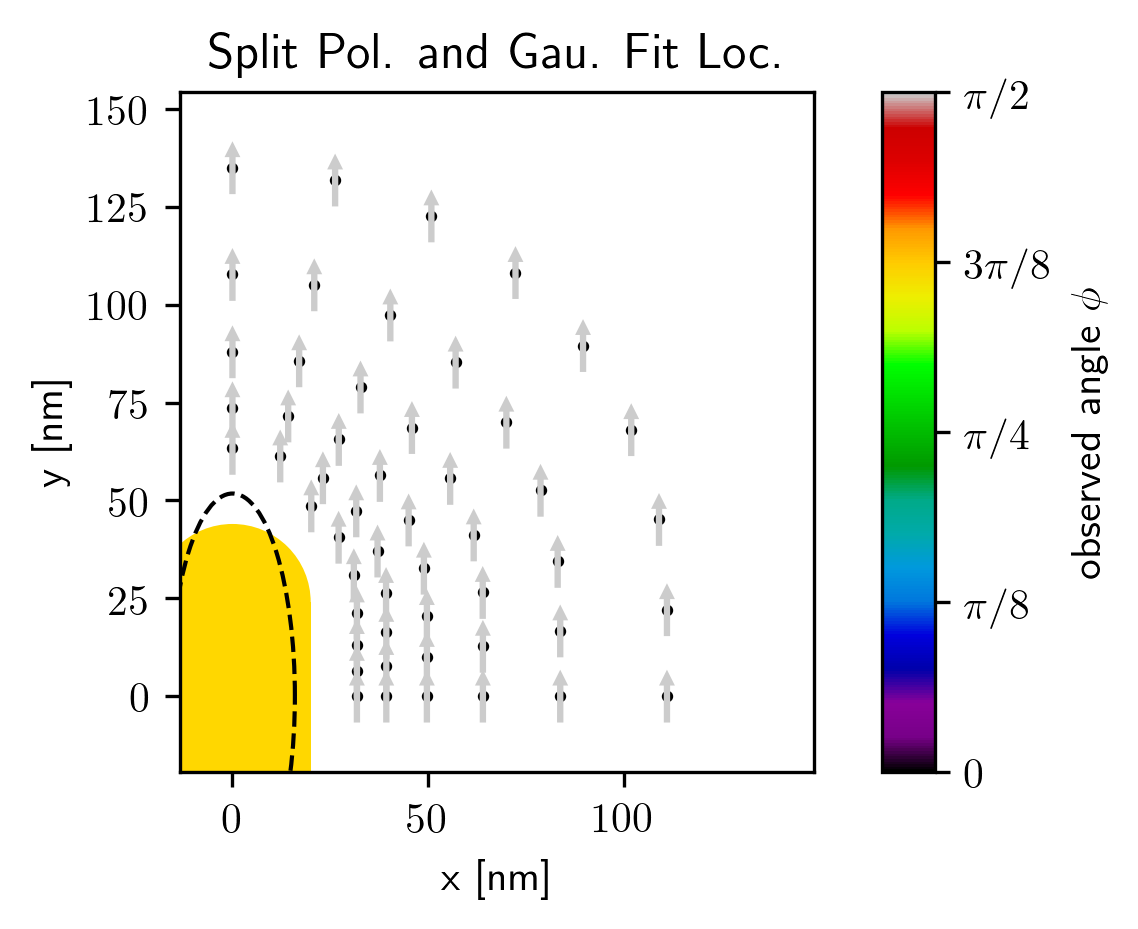

In [21]:
curly_mod_inst_y = fit.MolCoupNanoRodExp(
    curlys_dipole_locations, 
    mol_angle=np.pi/2, 
    isolate_mode='long', 
    drive_energy_eV=.24
    )
curly_mod_inst_y.plot_mispol_map()

Nope, its just the high energy shoulder of the long mode. 

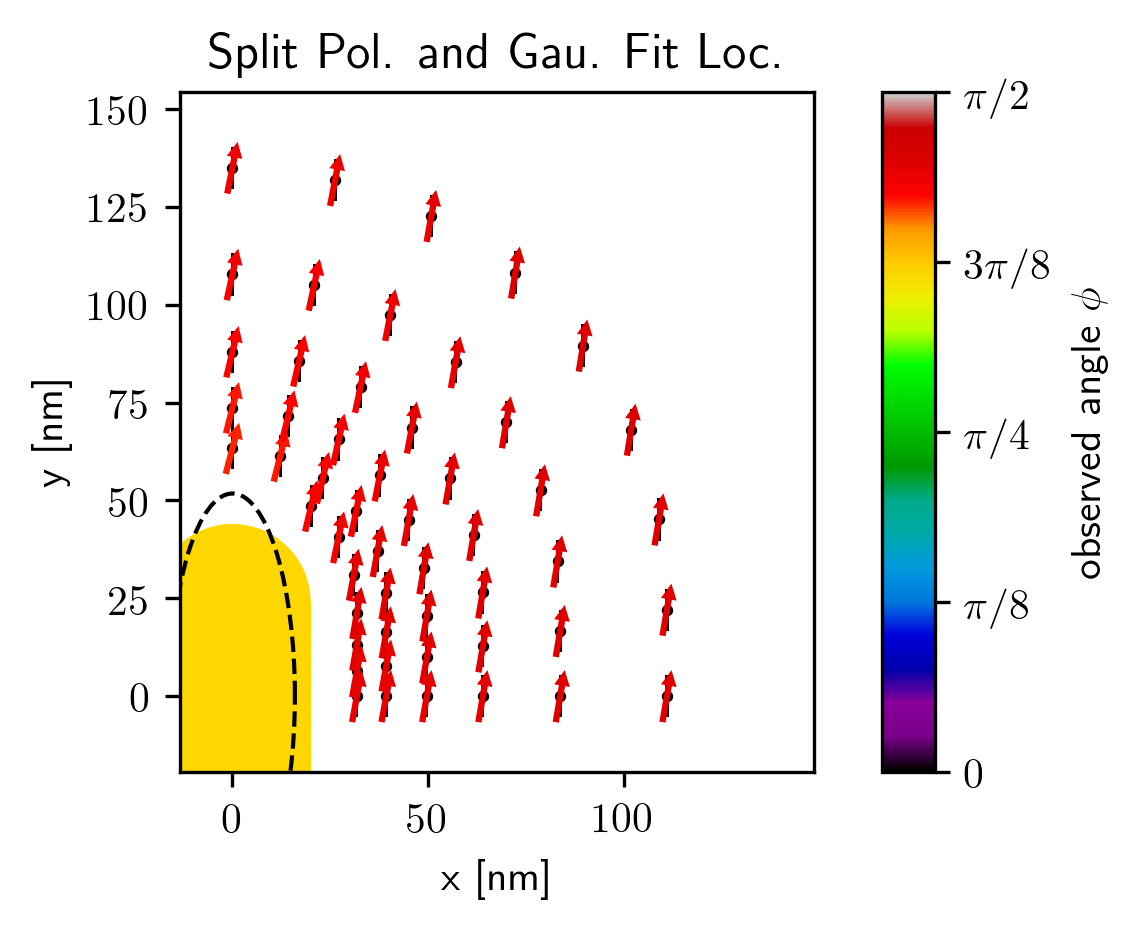

In [22]:
curly_mod_inst_y = fit.MolCoupNanoRodExp(
    curlys_dipole_locations, 
    mol_angle=np.pi/2, 
    isolate_mode='long', 
    drive_energy_eV=5.4
    )
curly_mod_inst_y.plot_mispol_map()

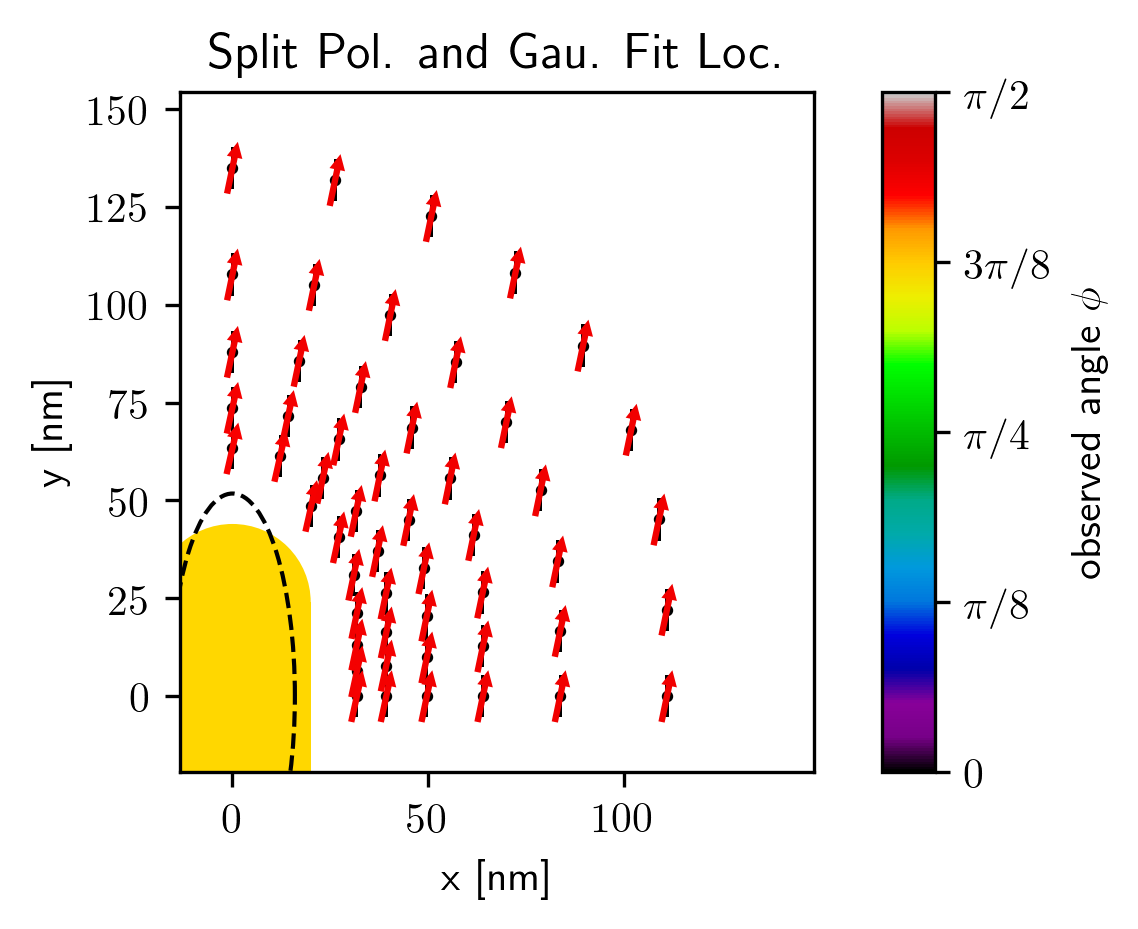

In [23]:
curly_mod_inst_y = fit.MolCoupNanoRodExp(
    curlys_dipole_locations, 
    mol_angle=np.pi/2, 
    isolate_mode='long', 
    drive_energy_eV=10.4
    )
curly_mod_inst_y.plot_mispol_map()